In [1]:
from pathlib import Path
from typing import Tuple
import functools

import pydicom

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.draw import polygon, polygon2mask


import torch
from torch.utils.data import random_split, DataLoader
from torchvision import transforms

In [2]:
import os, sys
sys.path.append(os.path.abspath('..'))

In [3]:
def get_points(path: Path) -> np.ndarray:
    with open(path, 'r') as f:
        lines = f.read().split('\n')
    
    # remove last line if empty
    if lines[-1] == '':
        lines = lines[:-1]
    return np.array([x_y.split(' ') for x_y in lines]).astype(np.float64)

In [4]:
def get_mask(shape: Tuple[int, int], path: Path) -> np.ndarray:

    pts = get_points(path)
    pg = polygon(pts[:, 1], pts[:, 0], shape)
    mask = polygon2mask(shape, np.array(pg).T)

    return mask

In [9]:
images: torch.Tensor = torch.Tensor()
labels: torch.Tensor = torch.Tensor()

folders = [
    (
        Path('../data/01_raw/Sunnybrook Cardiac MR Database ContoursPart1/OnlineDataContours'),
        Path('../data/01_raw/Sunnybrook Cardiac MR Database DICOMPart1/OnlineDataDICOM'),
    ),
    (
        Path('../data/01_raw/Sunnybrook Cardiac MR Database ContoursPart2/ValidationDataContours'),
        Path('../data/01_raw/Sunnybrook Cardiac MR Database DICOMPart2/ValidationDataDICOM'),
    ),
    (
        Path('../data/01_raw/Sunnybrook Cardiac MR Database ContoursPart3/TrainingDataContours'),
        Path('../data/01_raw/Sunnybrook Cardiac MR Database DICOMPart3/TrainingDataDICOM'),
    )
]

for contour_folder, dicom_folder in folders:

    patients = [d for d in contour_folder.iterdir() if d.is_dir()]

    for patient in patients:
        
        if patient.name == 'file-listings':
            continue

        contours = [f for f in (patient / 'contours-manual' / 'IRCCI-expert').iterdir() 
                        if (f.is_file() and f.suffix == '.txt')]
        
        cont_ptr = {}
        for contour in contours:
            _, _, no, _, _ = contour.stem.split('-')

            no = f"IM-0001-{int(no):04}"

            if no not in cont_ptr.keys():
                cont_ptr[no] = [contour]
            else:
                cont_ptr[no].append(contour)

        for no, conts in cont_ptr.items():
            # choose only inner and outer
            conts = [cont for cont in conts if ('icontour' in str(cont) or 'ocontour' in str(cont))]
            
            # skip annotations that don't include endo- and epi-cardial wall
            if len(conts) < 2:
                continue

            image_path = dicom_folder / patient.name / 'DICOM' / (no + '.dcm')
            image = pydicom.dcmread(image_path).pixel_array

            mask_me = functools.partial(get_mask, image.shape)
            # alphabetical sorting will yield inner before outer
            inner, outer = tuple(map(mask_me, sorted(conts)))

            label = (outer ^ inner).astype(np.float64)

            images = torch.cat((images, torch.Tensor(image).unsqueeze(0)), axis=0)
            labels = torch.cat((labels, torch.Tensor(label).unsqueeze(0)), axis=0)


In [10]:
len(images)

420

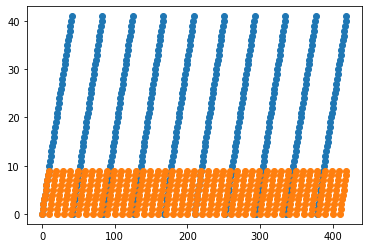

In [27]:
x = np.array(range(420))
y = x % 42
z = x % 10
plt.scatter(x, y)
plt.scatter(x, z)